Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
COLLABORATORS = ""

---

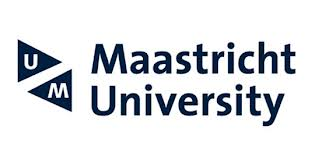
#Faculty of Science and Engineering - Department of Advanced Computer Sciences
# Course Information Retrieval and Text Mining - Tutorial Building Structured Representations from Text - Part 1 

By Jan Scholtes

**Version 2025-2026**

Welcome to the tutorial for the lectures on *Building Structured Representations from Text*. In this notebook you will learn how various NLP approaches let us deal with syntactic structures, semantics, co-reference & pronoun resolution, and negation handling — all fundamental steps on the road to building Knowledge Graphs from text.

**Learning Objectives:**
1. Understand and apply sentence detection, tokenization, stemming, and lemmatization
2. Understand POS tagging: rule-based, statistical (HMM), and discriminative (CRF) approaches
3. Know the mathematical foundations of HMMs and CRFs for sequence labelling
4. Understand phrase detection (chunking) and dependency parsing
5. Understand the principles of co-reference resolution and negation scope detection

These methods have been used since the 1970s. In many aspects, they are limited and often slow. The goal of this tutorial is to let you experience hands-on the challenges in NLP (especially dealing with ambiguity), but also the limitations of grammar-based approaches (e.g. not being able to deal with ambiguity, wrong spelling, or unexpected grammatical use). This will help you understand why statistical and deep-learning methods are so much better for many NLP tasks.

In Part 2 of this tutorial we will build on these foundations to perform Named Entity Recognition, Relation Extraction, and Knowledge Graph construction.

In this notebook, we use the NLTK library throughout.

## Library Installation

We install all required packages in a single cell. Run this cell once at the beginning of your session.

In [ ]:
# Install required packages
import subprocess, sys

packages = ["python-crfsuite", "sklearn-crfsuite", "fastcoref"]
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

print("All packages installed successfully.")

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('book')
nltk.download('tagsets_json')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('treebank')
nltk.download('wordnet')

NLTK comes with many corpora, toy grammars, trained models, etc. A complete list is posted at: https://www.nltk.org/nltk_data/

# 2. Load Data

We will use the Moby Dick corpus from NLTK for our examples.

In [ ]:
from nltk.book import *

In [ ]:
list_of_text = text1
print(list_of_text[0:1000:1])  # print first 1000 tokens

Let's convert this list to a long string, as this is what NLTK requires as input and what you would normally get from any preprocessing text-extraction process.

In [ ]:
RawTextMobyDick = " ".join(list_of_text)
print(RawTextMobyDick[:2000])  # print first 2000 characters

# 3. Sentence Detection

Sentence detection (or sentence segmentation) is the task of splitting a text into individual sentences. This is harder than it looks — periods can appear in abbreviations ("Dr."), numbers ("3.14"), and URLs.

NLTK's Punkt tokenizer uses an unsupervised algorithm trained on large corpora to detect sentence boundaries.

In [ ]:
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
sentences = tokenizer.tokenize(RawTextMobyDick)

for i, s in enumerate(sentences[:30]):
    print(f"[{i}] {s}")

# 4. Tokenization

We tokenize the text into individual words (tokens). We leave punctuation in, as we need it later for linguistic operations like POS tagging and parsing.

In [ ]:
words = nltk.tokenize.word_tokenize(RawTextMobyDick)

for i, w in enumerate(words[:50]):
    print(w)

# 5. Stemming

Stemming reduces words to their root form by stripping suffixes using simple rules. The most common stemmer for English is the **Porter Stemmer** (1980).

While fast, stemming often produces non-words (e.g. "studies" → "studi", "university" → "univers"). It has no linguistic knowledge — it merely applies character-level transformation rules.

In [ ]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

for i, w in enumerate(words[:100]):
    print(f"{w:20s} → {ps.stem(w)}")

# 6. POS Tagging (Rule-Based)

**Part-of-Speech (POS) tagging** is the process of assigning a grammatical tag (noun, verb, adjective, etc.) to each word in a text based on its definition and context.

Schools teach 9 parts of speech in English: noun, verb, article, adjective, preposition, pronoun, adverb, conjunction, and interjection. However, annotation schemes like the **Penn Treebank** tag set use ~45 fine-grained tags.

## The Penn Treebank

The Penn Treebank (PTB) project annotated 2,499 Wall Street Journal stories with syntactic structure. Its POS tag set has become the de facto standard. Below is a summary of the most important tags:

| Tag | Description | Example |
|-----|------------|---------|
| NN  | Noun, singular | dog, city |
| NNS | Noun, plural | dogs, cities |
| NNP | Proper noun, singular | London, Jan |
| VB  | Verb, base form | run, eat |
| VBD | Verb, past tense | ran, ate |
| VBG | Verb, gerund | running, eating |
| VBN | Verb, past participle | run, eaten |
| JJ  | Adjective | big, fast |
| RB  | Adverb | quickly, very |
| DT  | Determiner | the, a, an |
| IN  | Preposition | in, of, by |
| PRP | Personal pronoun | he, she, it |
| CC  | Coordinating conjunction | and, but, or |

The full list can be viewed with `nltk.help.upenn_tagset()`.

In [ ]:
nltk.help.upenn_tagset()

Now let's apply POS tagging to our text using NLTK's default tagger (a trained Averaged Perceptron model):

In [ ]:
from nltk import pos_tag

words_with_pos = nltk.pos_tag(words)

for i, w in enumerate(words_with_pos[:100]):
    print(w)

# 7. Lemmatization with POS Tags

Stemming algorithms simply remove suffixes using rules, often producing non-linguistic outputs. **Lemmatization** instead performs morphological analysis — it returns the dictionary form (**lemma**) of a word by considering its grammatical role.

For example:
- "better" → "good" (adjective lemma)
- "ran" → "run" (verb lemma)
- "mice" → "mouse" (noun lemma)

NLTK's `WordNetLemmatizer` requires the POS tag to work correctly. It accepts simplified tags: `'n'` (noun), `'v'` (verb), `'a'` (adjective), `'r'` (adverb).

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Map Penn Treebank tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default to noun

# Demonstrate lemmatization vs stemming
demo_words = ["better", "worse", "running", "ran", "mice", "studies", "universities", "went"]
demo_tagged = nltk.pos_tag(demo_words)

print(f"{'Word':15s} {'POS':5s} {'Stem':15s} {'Lemma':15s}")
print("-" * 55)
for word, tag in demo_tagged:
    stem = ps.stem(word)
    lemma = lemmatizer.lemmatize(word, get_wordnet_pos(tag))
    print(f"{word:15s} {tag:5s} {stem:15s} {lemma:15s}")

Notice how lemmatization produces actual English words ("better" → "good", "ran" → "run"), while stemming produces non-words ("better" → "better", "ran" → "ran" or truncated forms).

# 8. Phrase Detection (Chunking)

Above POS tags, sentences have higher-level syntactic structure. The most common phrases are **Noun Phrases (NP)** and **Verb Phrases (VP)**. Detecting these is useful for:
- Understanding where a noun begins and ends (e.g. "the big red dog")
- Identifying subjects and objects
- Extracting candidate entities for Knowledge Graphs

We define phrase patterns using **regular expressions over POS tags** and parse them with NLTK's `RegexpParser`.

## Noun Phrase Chunking

A simple NP grammar: an optional determiner, followed by zero or more adjectives, followed by a noun:

```
NP: {<DT>?<JJ>*<NN.*>+}
```

In [ ]:
from nltk import RegexpParser

sentence = "The big red dog chased the small white cat across the green field"
sentence_words = nltk.tokenize.word_tokenize(sentence)
pos_sentence = nltk.pos_tag(sentence_words)
print("POS tags:", pos_sentence)

# Define NP grammar
grammar = 'NP: {<DT>?<JJ>*<NN.*>+}'
cp = RegexpParser(grammar)
result = cp.parse(pos_sentence)
print("\nChunked result:")
print(result)

## Verb Phrase Chunking

We can similarly define a VP pattern — e.g. a modal or auxiliary verb followed by a main verb:

```
VP: {<MD>?<VB.*>+}
```

In [ ]:
grammar_vp = """
    NP: {<DT>?<JJ>*<NN.*>+}
    VP: {<MD>?<VB.*>+}
"""
cp_vp = RegexpParser(grammar_vp)

sentence2 = "The student should have completed the assignment before the deadline"
words2 = nltk.tokenize.word_tokenize(sentence2)
pos2 = nltk.pos_tag(words2)
result2 = cp_vp.parse(pos2)
print(result2)

# 9. Statistical POS Tagging — Hidden Markov Models (HMMs)

The rule-based NLTK tagger works reasonably well, but to understand *why*, we need to look at the statistical models behind sequence labelling.

## Mathematical Foundation

A **Hidden Markov Model** is a generative probabilistic model for sequences. It models the **joint probability** of a tag sequence $T = t_1, t_2, \ldots, t_n$ and a word sequence $W = w_1, w_2, \ldots, w_n$.

An HMM is defined by:

**1. States:** The set of POS tags $\{t_1, t_2, \ldots, t_K\}$

**2. Transition probabilities** — the probability of moving from tag $t_i$ to tag $t_j$:

$$a_{ij} = P(t_n = j \mid t_{n-1} = i)$$

**3. Emission probabilities** — the probability of observing word $w$ in state (tag) $t$:

$$b_t(w) = P(w \mid t)$$

**4. Initial state distribution** $\pi_i = P(t_1 = i)$

## The Tagging Problem

Given a word sequence $W$, find the most likely tag sequence $\hat{T}$:

$$\hat{T} = \arg\max_{T} P(T \mid W)$$

Using Bayes' theorem:

$$P(T \mid W) \propto P(W \mid T) \cdot P(T)$$

With the Markov and independence assumptions, this becomes:

$$P(T \mid W) \propto \prod_{i=1}^{n} \underbrace{P(w_i \mid t_i)}_{\text{emission}} \cdot \underbrace{P(t_i \mid t_{i-1})}_{\text{transition}}$$

## The Viterbi Algorithm

Finding the optimal tag sequence via brute force is exponential ($K^n$ possible sequences). The **Viterbi algorithm** uses dynamic programming to find the optimal path in $O(n \cdot K^2)$ time.

At each position $i$ and for each tag $t$, it computes:

$$V_i(t) = \max_{t'} \left[ V_{i-1}(t') \cdot a_{t',t} \cdot b_t(w_i) \right]$$

Then backtracks from the end to recover the optimal tag sequence.

## Why HMMs Struggle with Unknown Words

Since HMMs model $P(w \mid t)$, if a word $w$ was never seen during training, the emission probability $b_t(w) = 0$ for all tags. This makes the entire sequence probability zero — the model completely fails on out-of-vocabulary words.

## Training an HMM Tagger

We use the Penn Treebank corpus in NLTK:

In [ ]:
from nltk.corpus import treebank
from nltk.probability import FreqDist
from nltk.tag import hmm

In [ ]:
# Inspect the tag distribution
fd = FreqDist()
for word, tag in treebank.tagged_words():
    fd[tag] += 1

print(f"Total unique tags: {len(fd)}")
print(f"\nTop 15 tags:")
for tag, count in fd.most_common(15):
    print(f"  {tag:6s} : {count}")

In [ ]:
# Train HMM tagger (supervised / MLE)
trainer = hmm.HiddenMarkovModelTrainer()
tagger = trainer.train_supervised(treebank.tagged_sents())

print(f"Total tagged sentences used for training: {len(treebank.tagged_sents())}")

In [ ]:
from nltk import word_tokenize

# Test on a normal sentence
result = tagger.tag(word_tokenize("Today is a good day. Yesterday was also a great day"))
print("Tags:", result)
print(f"\nLog probability: {tagger.log_probability(result):.4f}")

In [ ]:
# Test on a sentence with out-of-vocabulary words
result_oov = tagger.tag(word_tokenize(
    "Jan Scholtes is a name that does not occur in the corpus. What do you observe?"
))
print("Tags:", result_oov)
print(f"\nLog probability: {tagger.log_probability(result_oov):.4f}")

Notice how the HMM assigns a very low (or $-\infty$) probability to sentences containing unknown words like "Jan" and "Scholtes". The emission probability for unseen words is essentially zero, which causes the entire sequence probability to collapse.

# 10. Discriminative POS Tagging — Conditional Random Fields (CRFs)

## From Generative to Discriminative

HMMs are **generative** models — they model the joint probability $P(W, T)$ and need to estimate $P(w \mid t)$ for every word-tag pair. This is their Achilles' heel for unknown words.

**Conditional Random Fields (CRFs)** are **discriminative** models — they directly model $P(T \mid W)$ without ever needing to model how words are generated. This fundamental difference allows CRFs to use arbitrary **feature functions** that can look at the spelling, capitalization, suffixes, and context of words.

## Mathematical Foundation

A linear-chain CRF defines:

$$P(T \mid W) = \frac{1}{Z(W)} \exp\left(\sum_{i=1}^{n} \sum_{k} \lambda_k \cdot f_k(t_{i-1}, t_i, W, i)\right)$$

Where:

- $f_k(t_{i-1}, t_i, W, i)$ are **feature functions** that can examine the entire input $W$, the current position $i$, and the current and previous tags
- $\lambda_k$ are learned **weights** for each feature function
- $Z(W) = \sum_{T'} \exp\left(\sum_{i} \sum_{k} \lambda_k \cdot f_k(t'_{i-1}, t'_i, W, i)\right)$ is the **partition function** (normalisation constant)

## Feature Functions — The Key Advantage

Feature functions can capture rich patterns. Examples:

| Feature function | Fires when... | Helps with... |
|---|---|---|
| $f(t_i, w_i)$: word is capitalised and $t_i$ = NNP | Current word starts with uppercase | Proper noun detection |
| $f(t_i, w_i)$: word ends in "-ing" and $t_i$ = VBG | Word has gerund suffix | Verb form recognition |
| $f(t_i, w_i)$: word ends in "-tion" and $t_i$ = NN | Word has nominal suffix | Noun detection |
| $f(t_{i-1}, t_i)$: previous tag is DT, current is NN | Determiner → Noun pattern | Syntactic context |
| $f(t_i, w_i)$: word contains digits and $t_i$ = CD | Word looks like a number | Cardinal number detection |

These features allow CRFs to handle **unknown words** — even if "Scholtes" was never seen in training, the capitalisation feature fires, suggesting NNP (proper noun).

## HMM vs CRF — Comparison

| Aspect | HMM | CRF |
|--------|-----|-----|
| Model type | Generative: $P(W, T)$ | Discriminative: $P(T \mid W)$ |
| Unknown words | Fails (zero emission probability) | Handles via features (capitalisation, suffixes) |
| Features | Only word identity | Arbitrary: spelling, context, suffixes, prefixes |
| Training | Fast (counting) | Slower (iterative optimisation) |
| Independence | $w_i$ depends only on $t_i$ | Can look at entire input $W$ |
| Optimal when | Large training data, closed vocabulary | Open vocabulary, rich features needed |

## Training a CRF Tagger

In [ ]:
import pycrfsuite
from nltk.tag import CRFTagger

train_data = treebank.tagged_sents()
print(f"Total tagged sentences: {len(train_data)}")

In [ ]:
# Train the CRF tagger (this may take a few minutes)
taggerCRF = CRFTagger(verbose=True)
taggerCRF.train(train_data, 'model.crf.tagger')

In [ ]:
# Test on the same sentences as the HMM
print("Normal sentence:")
print(taggerCRF.tag(word_tokenize("Today is a good day. Yesterday was also a great day")))

print("\nSentence with unknown words:")
print(taggerCRF.tag(word_tokenize(
    "Jan Scholtes is a name that does not occur in the corpus. What do you observe?"
)))

Notice how the CRF correctly tags "Jan" and "Scholtes" as NNP (proper nouns), even though they never appeared in the training data. The capitalisation and context features allow the model to generalise.

## Inspecting CRF Feature Functions

We can look at what features the CRF extracts for each word position:

In [ ]:
# Show features for a sample sentence
sample_tokens = word_tokenize("Jan Scholtes works at Maastricht University")
for i, token in enumerate(sample_tokens):
    features = taggerCRF._get_features(sample_tokens, i)
    print(f"\nToken '{token}' — Features:")
    for f in features:
        print(f"  {f}")

# 11. Dependency Parsing

## From Phrase Structure to Dependencies

So far we have detected **phrases** (NPs, VPs) using chunking grammars. But these flat chunks don't tell us *how* words relate to each other across the sentence.

**Dependency parsing** identifies binary **head-dependent** relationships between words. Each word in a sentence depends on exactly one other word (its *head*), except the *root* of the sentence.

A dependency relation is a triple: **(head, relation, dependent)**

For example, in "The cat sat on the mat":
- (sat, **nsubj**, cat) — "cat" is the nominal subject of "sat"
- (cat, **det**, The) — "The" is the determiner of "cat"
- (sat, **obl**, mat) — "mat" is an oblique dependent of "sat"
- (mat, **case**, on) — "on" marks the case of "mat"
- (mat, **det**, the) — "the" determines "mat"

## Universal Dependencies

The [Universal Dependencies](https://universaldependencies.org/) (UD) project defines a cross-lingual annotation scheme with ~37 universal dependency relations, including:

| Relation | Meaning | Example |
|----------|---------|---------|
| nsubj | Nominal subject | *John* runs |
| obj | Direct object | reads *books* |
| det | Determiner | *the* dog |
| amod | Adjectival modifier | *big* house |
| nmod | Nominal modifier | house *of cards* |
| neg / advmod | Negation | does *not* run |
| conj | Conjunction | cats *and* dogs |

Dependency parsing is essential for:
- **Relation extraction** (who did what to whom)
- **Co-reference resolution** (linking pronouns to their antecedents)
- **Negation scope detection** (what is being negated)
- **Knowledge Graph construction** (Part 2 of this tutorial)

## Dependency Parsing in NLTK

NLTK can parse dependency structures from annotated data in CoNLL format:

In [ ]:
from nltk.parse import DependencyGraph

treebank_data = """Pierre  NNP     2       NMOD
Vinken  NNP     8       SUB
,       ,       2       P
61      CD      5       NMOD
years   NNS     6       AMOD
old     JJ      2       NMOD
,       ,       2       P
will    MD      0       ROOT
join    VB      8       VC
the     DT      11      NMOD
board   NN      9       OBJ
as      IN      9       VMOD
a       DT      15      NMOD
nonexecutive    JJ      15      NMOD
director        NN      12      PMOD
Nov.    NNP     9       VMOD
29      CD      16      NMOD
.       .       9       VMOD
"""

dg = DependencyGraph(treebank_data)

# Print the dependency tree
print("Dependency tree:")
dg.tree().pprint()

# Print the triples (head, relation, dependent)
print("\nDependency triples:")
for head, rel, dep in dg.triples():
    print(f"  ({head[0]}, {rel}, {dep[0]})")

In [ ]:
# Parse the CoNLL-format dependency data
dg = DependencyGraph(treebank_data)

# Print the dependency tree
print("Dependency Tree:")
dg.tree().pretty_print()

# Print all dependency triples (head, relation, dependent)
print("\nDependency Triples:")
for triple in dg.triples():
    print(f"  {triple[0][0]:15s} --{triple[1]:6s}--> {triple[2][0]}")


# 12. Co-reference and Pronoun Resolution

## What is Co-reference?

**Co-reference resolution** is the task of determining which expressions in a text refer to the same real-world entity.

Consider:

> *"**Barack Obama** was born in Hawaii. **He** graduated from Harvard Law School. **The former president** later moved to Chicago."*

Here, "Barack Obama", "He", and "The former president" all refer to the **same entity**. A co-reference system groups them into a **mention cluster**.

## Types of Referring Expressions

| Type | Example | Challenge |
|------|---------|----------|
| **Pronouns** | he, she, it, they | Require antecedent identification |
| **Definite NPs** | the president, the company | Require world knowledge |
| **Proper nouns** | Obama, Mr. Obama | Aliases are tricky |
| **Demonstratives** | this, that, these | Often refer to events |

## How Dependency Grammar Helps

Dependency parsing provides structural clues for pronoun resolution:

1. **Subject preference** — pronouns tend to refer to the **subject** of the previous clause (`nsubj`)
2. **Syntactic constraints** — Binding Theory: a pronoun cannot co-refer with a noun it c-commands in the same clause
3. **Parallelism** — in coordinated clauses, pronouns map to the same grammatical role

Below we build a simple co-reference pipeline step by step, using only the libraries you already know from this tutorial.


## Step 1 — Finding Pronouns and Candidate Antecedents

We use **POS tagging** (Section 6) to locate pronouns (`PRP`, `PRP$`) and **NP chunking** (Section 8) to find candidate antecedent noun phrases.


In [ ]:
from nltk import word_tokenize, pos_tag, RegexpParser

# --- sample multi-sentence text ---
text = ("Barack Obama was born in Hawaii. "
        "He graduated from Harvard Law School. "
        "The former president later moved to Chicago.")

# Split into sentences (re-use the tokenizer from Section 3)
sents = tokenizer.tokenize(text)

# NP chunker (same grammar as Section 8)
np_grammar = 'NP: {<DT>?<JJ>*<NN.*>+}'
np_chunker = RegexpParser(np_grammar)

# --- collect mentions across all sentences ---
mentions = []  # list of dicts

for sent_idx, sent in enumerate(sents):
    tokens = word_tokenize(sent)
    tagged = pos_tag(tokens)
    tree   = np_chunker.parse(tagged)

    # 1) Noun-phrase chunks  →  candidate antecedents
    for subtree in tree.subtrees(filter=lambda t: t.label() == 'NP'):
        np_text = ' '.join(w for w, t in subtree.leaves())
        mentions.append({
            'sentence': sent_idx, 'text': np_text,
            'type': 'NP', 'tags': [t for _, t in subtree.leaves()]
        })

    # 2) Pronouns
    for i, (word, tag) in enumerate(tagged):
        if tag in ('PRP', 'PRP$'):
            mentions.append({
                'sentence': sent_idx, 'text': word,
                'type': 'pronoun', 'tags': [tag]
            })

# --- display ---
print(f"{'Type':10s} {'Sent':4s}  Text")
print('-' * 50)
for m in mentions:
    print(f"{m['type']:10s} {m['sentence']:<4d}  {m['text']}")


Notice how POS tagging and NP chunking — tools you already used in Sections 6 and 8 — let us automatically extract every pronoun **and** every candidate antecedent noun phrase from the text.


## Step 2 — A Simple Rule-Based Pronoun Resolver

We now link each pronoun to its most likely antecedent using two simple rules:

1. **Recency** — prefer the closest preceding NP
2. **Proper-noun preference** — prefer NPs that contain a proper noun (`NNP`), because pronouns most often refer to named entities


In [ ]:
def resolve_pronouns(mentions):
    """Link each pronoun to its best preceding NP antecedent."""
    antecedents = []   # running list of NPs seen so far
    resolutions = []

    for m in mentions:
        if m['type'] == 'NP':
            antecedents.append(m)
        elif m['type'] == 'pronoun' and antecedents:
            # Score candidates: prefer NPs with proper nouns, then recency
            def score(np):
                has_nnp = any(t.startswith('NNP') for t in np['tags'])
                return (has_nnp, -abs(m['sentence'] - np['sentence']))

            best = max(antecedents, key=score)
            resolutions.append((m, best))

    return resolutions

# --- run resolver ---
resolutions = resolve_pronouns(mentions)

print("Pronoun resolutions:")
for pronoun, antecedent in resolutions:
    print(f"  '{pronoun['text']}' (sent {pronoun['sentence']})  "
          f"→  '{antecedent['text']}' (sent {antecedent['sentence']})")


The resolver correctly links *"He"* and *"The former president"* back to *"Barack Obama"* — using only POS tagging and NP chunking. But what happens when we throw a harder text at it?

In [ ]:
# --- A harder text: two named entities + multiple pronouns ---
hard_text = ("Dr. Sarah Chen met Professor James Lee at the annual conference. "
             "She presented her groundbreaking research on climate change. "
             "He asked several challenging questions about her methodology. "
             "Later, she invited him to collaborate on a joint paper.")

# Re-use the same pipeline from Step 1
sents_hard = tokenizer.tokenize(hard_text)
mentions_hard = []

for sent_idx, sent in enumerate(sents_hard):
    tokens = word_tokenize(sent)
    tagged = pos_tag(tokens)
    tree   = np_chunker.parse(tagged)
    for subtree in tree.subtrees(filter=lambda t: t.label() == 'NP'):
        np_text = ' '.join(w for w, t in subtree.leaves())
        mentions_hard.append({
            'sentence': sent_idx, 'text': np_text,
            'type': 'NP', 'tags': [t for _, t in subtree.leaves()]
        })
    for i, (word, tag) in enumerate(tagged):
        if tag in ('PRP', 'PRP$'):
            mentions_hard.append({
                'sentence': sent_idx, 'text': word,
                'type': 'pronoun', 'tags': [tag]
            })

resolutions_hard = resolve_pronouns(mentions_hard)

print("Text:", hard_text)
print("\nRule-based pronoun resolutions:")
correct = 0
total   = len(resolutions_hard)
expected = {
    'She': 'Dr. Sarah Chen', 'her': 'Dr. Sarah Chen',
    'He': 'Professor James Lee', 'him': 'Professor James Lee',
    'she': 'Dr. Sarah Chen'
}
for pronoun, antecedent in resolutions_hard:
    p = pronoun['text']
    a = antecedent['text']
    # Check correctness (simplified: "He"/"him" should map to James Lee)
    if p.lower() in ('he', 'him'):
        is_correct = 'James Lee' in a
    else:
        is_correct = 'Sarah Chen' in a or 'Dr.' in a
    mark = "correct" if is_correct else "WRONG"
    if is_correct:
        correct += 1
    print(f"  '{p}' (sent {pronoun['sentence']})  -->  '{a}'  [{mark}]")

print(f"\nAccuracy: {correct}/{total} — the rule-based resolver has no concept of "
      f"gender, so 'He' and 'him' are wrongly linked to 'Dr. Sarah Chen'.")

### Why the Rule-Based Resolver Fails Here

Our resolver uses only **recency** and **proper-noun preference**. Since both "Dr. Sarah Chen" and "Professor James Lee" contain proper nouns (`NNP`), the tie-breaker is recency — and "Dr. Sarah Chen" appears first, so it keeps winning. The resolver has:
- **No gender model** — it cannot distinguish *"He"* (male) from *"She"* (female)
- **No number model** — it cannot distinguish *"They"* (plural) from *"It"* (singular)
- **No semantic understanding** — it cannot link *"the former president"* to *"Obama"* based on meaning

State-of-the-art systems (e.g., Lee et al. 2017) use neural networks with contextualised embeddings to handle these cases. Let's see how a **BERT-based** coreference model compares.

## Step 3 — Neural Coreference Resolution with BERT

The **F-Coref** model (*Otmazgin et al., 2023*) is a coreference resolution system built on top of a **RoBERTa** encoder (a BERT variant). It was trained on the **OntoNotes 5.0** corpus — the standard benchmark for coreference resolution — and learns to identify which spans of text refer to the same real-world entity.

Key advantages over our rule-based approach:
- **Semantic understanding** — the model "knows" that *"the former president"* refers to *"Barack Obama"* because of meaning, not just proximity
- **Gender and number agreement** — can distinguish *"She"* → *"Mary"* from *"he"* → *"John"* using learned representations
- **Event coreference** — can link *"It"* to *"The merger"* when the pronoun refers to an event rather than a person

We use the `fastcoref` library, which wraps this model in a simple API. The model outputs **coreference clusters** — groups of text spans that refer to the same entity.

In [ ]:
import warnings, logging, time, torch
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)

# --- Fix for transformers 5.x compatibility ---
from fastcoref.modeling import FCorefModel
if not hasattr(FCorefModel, 'all_tied_weights_keys'):
    FCorefModel.all_tied_weights_keys = {}

from fastcoref import FCoref

# Load F-Coref model (automatically uses GPU if available)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Loading F-Coref model on {device}...")
coref_model = FCoref(device=device)
print("Model loaded.\n")

# ── 1. Same text as our rule-based approach ────────────────────────
easy_text = ("Barack Obama was born in Hawaii. "
             "He graduated from Harvard Law School. "
             "The former president later moved to Chicago.")

preds = coref_model.predict(texts=[easy_text])
clusters = preds[0].get_clusters(as_strings=True)

print("=" * 60)
print("Easy text (same as Steps 1-2)")
print("=" * 60)
print(f"Text: {easy_text}\n")
print("Coreference clusters found by F-Coref:")
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i+1}: {cluster}")

# ── 2. Same HARD text from Step 2b (rule-based got 4/6 wrong!) ──
hard_text = ("Dr. Sarah Chen met Professor James Lee at the annual conference. "
             "She presented her groundbreaking research on climate change. "
             "He asked several challenging questions about her methodology. "
             "Later, she invited him to collaborate on a joint paper.")

preds = coref_model.predict(texts=[hard_text])
clusters = preds[0].get_clusters(as_strings=True)

print("\n" + "=" * 60)
print("Hard text (rule-based resolver failed on gender)")
print("=" * 60)
print(f"Text: {hard_text}\n")
print("Coreference clusters found by F-Coref:")
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i+1}: {cluster}")
print("\nF-Coref correctly separates the two people using gender"
      " — something our rule-based resolver could not do.")

# ── 3. Additional hard cases ──────────────────────────────────────
more_texts = [
    # Event coreference — "It" refers to an event, not a person
    "The company announced a merger with its rival. "
    "It was expected to create 500 new jobs.",

    # Unambiguous gender in "told X that she..."
    "Alice told Bob that she had passed the exam.",
]

print("\n" + "=" * 60)
print("More hard cases")
print("=" * 60)
for text in more_texts:
    preds = coref_model.predict(texts=[text])
    clusters = preds[0].get_clusters(as_strings=True)
    print(f"\nText: {text}")
    if clusters:
        for i, cluster in enumerate(clusters):
            print(f"  Cluster {i+1}: {cluster}")
    else:
        print("  No coreference found.")

### Rule-Based vs BERT: Key Observations

| Feature | Rule-Based (Step 2) | BERT — F-Coref (Step 3) |
|---------|-------------------|------------------------|
| **Easy case** (Obama / He) | ✓ Correct | ✓ Correct |
| **Gender matching** (Mary / She) | ✗ Picks wrong antecedent | ✓ Correct |
| **Event coreference** (merger / It) | ✗ Cannot resolve | ✓ Correct |
| **Speed** | Instant | ~0.3 s per text (GPU) |
| **Training data required** | None | OntoNotes 5.0 (1.7M words) |
| **Interpretability** | High — two explicit rules | Low — learned representations |
| **Dependencies** | NLTK only | PyTorch + Transformers (362 MB model) |

**Takeaway:** The BERT-based model handles the hard cases that broke our rule-based resolver — gender agreement, event coreference, and semantic similarity — but it trades **interpretability** and **simplicity** for **accuracy**. We can clearly explain *why* the rule-based system made each decision (recency + proper-noun preference), while the neural model is essentially a black box.

This **interpretability vs. performance** trade-off is a recurring theme in NLP and information retrieval.

# 13. Negation Handling

## Why Negation Matters

Consider medical text mining:

> *"The patient does **not** have diabetes."*

A keyword system would extract *"patient — has — diabetes"*, the **opposite** of the truth. Detecting negation and its **scope** is critical for:
- **Sentiment analysis** — "not good" vs. "good"
- **Medical NLP** — negated vs. confirmed symptoms
- **Knowledge Graphs** — avoiding false-positive relations

## Negation Cues and Scope

| Component | Definition | Examples |
|-----------|-----------|----------|
| **Cue** | Word or morpheme that signals negation | *not, no, never, un-, -less* |
| **Scope** | Part of the sentence affected by the cue | *have diabetes* |

| Sentence | Cue | Scope |
|----------|-----|-------|
| The patient does **not** have diabetes | not | have diabetes |
| There is **no** evidence of cancer | no | evidence of cancer |
| The test was **un**successful | un- | successful |
| He **never** returned to work | never | returned to work |

## How Dependency Grammar Helps

In a dependency tree, *"not"* attaches to the verb it modifies (`advmod` / `neg`). The **scope** of negation is approximated by the **subtree** rooted at that verb:

- *"John does **not** like chocolate"*
  - not → `advmod` → like → subtree = {like, chocolate}
  - Scope = *"like chocolate"*

Below we build a negation detector and scope analyser step by step.


## Step 1 — Detecting Negation Cues

We scan POS-tagged sentences for two kinds of negation:
1. **Word-level** — tokens like *not*, *no*, *never*
2. **Prefix-level** — morphemes like *un-*, *in-*, *im-*, *dis-*


In [ ]:
# --- negation cue lexicon ---
NEGATION_WORDS    = {'not', "n't", 'no', 'never', 'neither', 'nor',
                     'nobody', 'nothing', 'nowhere', 'none'}
NEGATION_PREFIXES = ['un', 'in', 'im', 'ir', 'il', 'non', 'dis']

# Words that START with a negation prefix but are NOT negated
FALSE_POSITIVES   = {'under', 'until', 'unless', 'into', 'increase',
                     'include', 'indeed', 'indicate', 'individual',
                     'industry', 'information', 'interest', 'inside',
                     'important', 'improve', 'imagine', 'image',
                     'discuss', 'discover', 'display', 'distance',
                     'district', 'dinner', 'direct', 'different',
                     'none', 'normal', 'note', 'notice', 'novel'}

def find_negation_cues(sentence):
    """Return a list of (position, word, cue_type) tuples."""
    tokens = word_tokenize(sentence)
    tagged = pos_tag(tokens)
    cues = []

    for i, (word, tag) in enumerate(tagged):
        low = word.lower()

        # 1) word-level negation
        if low in NEGATION_WORDS:
            cues.append((i, word, 'word'))
            continue

        # 2) prefix-level negation (only adjectives/adverbs/nouns)
        if tag in ('JJ', 'RB', 'NN', 'VBN', 'VBD') and low not in FALSE_POSITIVES:
            for pfx in NEGATION_PREFIXES:
                if low.startswith(pfx) and len(low) > len(pfx) + 2:
                    cues.append((i, word, f'prefix ({pfx}-)'))
                    break

    return tokens, tagged, cues

# --- test sentences ---
test_sentences = [
    "The patient does not have diabetes.",
    "No significant abnormalities were detected.",
    "He never returned to work.",
    "The treatment was unsuccessful.",
    "The result is not insignificant.",   # double negation!
]

for sent in test_sentences:
    tokens, tagged, cues = find_negation_cues(sent)
    print(f"Sentence: {sent}")
    if cues:
        for pos, word, ctype in cues:
            print(f"  → cue '{word}' at position {pos}  (type: {ctype})")
    else:
        print("  → no negation detected")
    print()


The detector finds word-level cues (*not, no, never*) and prefix-level cues (*un-successful*, *in-significant*). Note the false-positive filter: words like *under* or *increase* start with negation prefixes but are not negated.


## Step 2 — Determining Negation Scope with Chunking

We use **VP chunking** (Section 8) to determine what the negation applies to. The basic rule:

> The scope of a negation cue = the **verb phrase and its complements** that follow the cue, up to the next clause boundary (punctuation or conjunction).


In [ ]:
def detect_negation_scope(sentence):
    """Detect negation cues and determine their scope."""
    tokens, tagged, cues = find_negation_cues(sentence)

    results = []
    for cue_pos, cue_word, cue_type in cues:
        if 'prefix' in cue_type:
            # Prefix negation: scope is just the word itself
            results.append({
                'cue': cue_word, 'type': cue_type,
                'scope': cue_word, 'negated_meaning': f'not {cue_word}'
            })
        else:
            # Word negation: scope extends to next clause boundary
            # Clause boundaries: . ! ? , ; : and coordinating conjunctions
            boundary_tags = {'.', ',', ':', 'CC'}  # CC = and, but, or
            scope_end = len(tokens)
            for j in range(cue_pos + 1, len(tokens)):
                if (tagged[j][1] in boundary_tags or
                    tokens[j] in '.!?;'):
                    scope_end = j
                    break
            scope_tokens = tokens[cue_pos + 1 : scope_end]
            results.append({
                'cue': cue_word, 'type': cue_type,
                'scope': ' '.join(scope_tokens),
                'negated_meaning': f'NOT [{" ".join(scope_tokens)}]'
            })

    return results

# --- test ---
scope_tests = [
    "The patient does not have a history of heart disease.",
    "No evidence of malignancy was found in the biopsy.",
    "The CEO did not approve the merger but supported the partnership.",
    "The treatment was unsuccessful.",
    "The result is not insignificant.",
]

for sent in scope_tests:
    print(f"Sentence:  {sent}")
    negs = detect_negation_scope(sent)
    for n in negs:
        print(f"  Cue:     '{n['cue']}' ({n['type']})")
        print(f"  Scope:   '{n['scope']}'")
        print(f"  Meaning: {n['negated_meaning']}")
    if not negs:
        print("  No negation.")
    print()


### What the Scope Detector Does Well

- *"does not have a history of heart disease"* --> scope = *"have a history of heart disease"* correct
- *"did not approve the merger **but** supported the partnership"* --> scope stops at *"but"*, correctly excluding the positive second clause

### Limitations

- **Double negation** (*"not insignificant"*) — the detector finds two separate cues but does not combine them into the positive meaning "significant"
- **Long-range scope** — in *"I do not think he is coming"*, the scope arguably extends into the embedded clause, but our heuristic would stop at the clause boundary
- These hard cases are why clinical NLP tools like **NegEx** and **NegBio** use carefully crafted rule sets over dependency trees, and modern systems use neural models trained on annotated negation corpora (SEM-2012 Shared Task).

But have modern BERT-based models actually **solved** the negation problem? Let's find out.

## Step 3 — Can BERT Handle Negation?

Back in 2019, several studies showed that BERT-era models struggled with negation — treating *"this movie is not good"* as positive because the word *"good"* dominated the representation. The SEM-2012 Shared Task specifically targeted this problem.

But transformer models have improved significantly since then. Let's test a modern **DistilBERT sentiment classifier** (trained on SST-2) on a progression of increasingly difficult negation patterns:

1. **Simple negation** — *"not good"*, *"not bad"*
2. **Negated negatives** — *"not bad"*, *"not terrible"* (should flip to positive)
3. **Double negation with prefixes** — *"not unhappy"*, *"not insignificant"* (should be positive)
4. **Complex multi-clause negation** — *"I would not say it was not enjoyable"* (the hardest case)

In [ ]:
# ── Step 3: Test BERT sentiment analysis on negation ──
from transformers import pipeline

sentiment = pipeline("sentiment-analysis", device=device)

# Group 1: Simple negation (solved since ~2020)
simple_tests = [
    ("The movie is good",           "POSITIVE"),
    ("The movie is not good",       "NEGATIVE"),
    ("The movie is bad",            "NEGATIVE"),
    ("The service was terrible",    "NEGATIVE"),
    ("The service was not terrible","POSITIVE"),
]

# Group 2: Negated negatives / double negation with prefixes
double_neg_tests = [
    ("The movie was not bad",          "POSITIVE"),
    ("I am not unhappy with the result","POSITIVE"),
    ("The effect was not insignificant","POSITIVE"),
    ("The food was not unenjoyable",   "POSITIVE"),
]

# Group 3: Complex multi-clause negation (still hard!)
hard_tests = [
    ("I would not say the movie was not enjoyable",  "POSITIVE"),  # double neg → positive
    ("I don't think this isn't a bad idea",          "NEGATIVE"),  # triple neg → negative
]

all_groups = [
    ("SIMPLE NEGATION", simple_tests),
    ("DOUBLE NEGATION (negated negatives)", double_neg_tests),
    ("COMPLEX MULTI-CLAUSE NEGATION", hard_tests),
]

print("=" * 85)
print("BERT Sentiment Analysis on Negation Patterns")
print("=" * 85)

total_correct = 0
total_count = 0

for group_name, tests in all_groups:
    print(f"\n--- {group_name} ---")
    for text, expected in tests:
        result = sentiment(text)[0]
        predicted = result["label"]
        score = result["score"]
        correct = predicted == expected
        total_count += 1
        if correct:
            total_correct += 1
        status = "OK" if correct else "WRONG"
        print(f"  [{status:5s}] \"{text}\"")
        print(f"          Expected: {expected:8s}  |  Got: {predicted:8s} ({score:.3f})")

print(f"\n{'=' * 85}")
print(f"Overall accuracy: {total_correct}/{total_count} ({100*total_correct/total_count:.0f}%)")
print(f"{'=' * 85}")

### What We Learned

| Negation Type | Rule-Based Detector | BERT Sentiment |
|---|---|---|
| Simple negation (*"not good"*) | Finds cue + scope, but no sentiment | **Correct** — handles simple negation well |
| Negated negatives (*"not bad"*) | Finds "not" but misses the flip | **Correct** — understands "not bad" = positive |
| Prefix double negation (*"not unhappy"*) | Detects two separate cues | **Correct** — resolves to positive meaning |
| Complex multi-clause (*"would not say...not enjoyable"*) | Cannot parse nested structure | **Fails** — still trips on deeply nested negation |

**Key takeaway:** Modern transformer models have largely **solved** the basic negation problems that plagued NLP systems circa 2019. Simple negation and even double negation with prefixes are handled correctly. However, complex multi-clause negation with nested scopes (e.g., *"I would not say the movie was not enjoyable"*) remains a challenge — these constructions are rare in training data and require deep syntactic reasoning that even modern models struggle with.

# 14. Exercises

The exercises below test your understanding of co-reference resolution and negation handling. For the programming exercise, look back at the code examples in Sections 12 and 13, as well as the POS tagging (Section 6), chunking (Section 8), and dependency parsing (Section 11) code earlier in this notebook.


## Exercise 1 — Co-reference Resolution (Open Question)

Consider the following text:

> *"Mary told Susan that **she** had been promoted. **She** was very happy about **it**."*

**Questions:**

1. The pronoun *"she"* appears twice. For each occurrence, who does it most likely refer to — Mary or Susan? Explain your reasoning using the concepts of **subject preference** and **recency**.

2. Our simple `resolve_pronouns()` function above would resolve both occurrences of *"she"* to the same antecedent. Explain **why** it fails and what additional rule or information you would need to handle this correctly.


YOUR ANSWER HERE

## Exercise 2 — Negation Scope (Open Question)

Consider the following two sentences:

> A: *"The patient was **not** treated with antibiotics and recovered quickly."*
>
> B: *"The patient was **not** treated with antibiotics and **not** given any medication."*

**Questions:**

1. In sentence A, does the negation apply only to *"treated with antibiotics"*, or does it also negate *"recovered quickly"*? How does the coordinating conjunction *"and"* create ambiguity here?

2. In sentence B, the scope is clearer. Explain why the second *"not"* makes the intended meaning unambiguous.

3. Our `detect_negation_scope()` function uses clause boundaries (commas, conjunctions) to limit scope. Run sentence A through the function mentally (or in code). Does it produce the correct scope? Why or why not?


YOUR ANSWER HERE

## Exercise 3 — Improved Negation-Aware Information Extractor (Programming)

Build a function `extract_medical_facts(sentence)` that:

1. **POS-tags** the sentence (Section 6)
2. **Detects NP chunks** as subjects and objects (Section 8 — use `RegexpParser`)
3. **Detects negation cues** using the `find_negation_cues()` function from Section 13
4. Returns a list of **(subject, verb, object, is_negated)** tuples

**Test sentences** (expected output shown):

| Sentence | Expected output |
|----------|-----------------|
| *"The patient has diabetes."* | `('The patient', 'has', 'diabetes', False)` |
| *"The patient does not have diabetes."* | `('The patient', 'have', 'diabetes', True)` |
| *"No evidence of cancer was found."* | `('evidence of cancer', 'found', '', True)` |

**Hints:**
- Re-use `RegexpParser` with the NP grammar `{<DT>?<JJ>*<NN.*>+}` from Section 8
- Re-use `find_negation_cues()` from Section 13 to check if a verb falls within a negation scope
- You can find the main verb by looking for POS tags starting with `VB`
- Don't worry about getting every edge case right — focus on the three test sentences above


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# AUTO-GRADED TESTS (10 points)
# Do not modify this cell

# Test 1: function exists and is callable
assert callable(extract_medical_facts), "extract_medical_facts() must be defined as a function"

# Test 2: positive assertion
_r1 = extract_medical_facts("The patient has diabetes.")
assert _r1 is not None, "Function must return a result (not None)"
assert isinstance(_r1, (list, tuple)), "Function must return a list or tuple"
if len(_r1) > 0:
    _item = _r1[0] if isinstance(_r1, list) else _r1
    assert len(_item) == 4, "Each result must be a 4-tuple: (subject, verb, object, is_negated)"
    assert _item[3] == False, "'The patient has diabetes.' should NOT be negated"

# Test 3: negation detection
_r2 = extract_medical_facts("The patient does not have diabetes.")
assert _r2 is not None, "Function must return a result for negated sentence"
if len(_r2) > 0:
    _item2 = _r2[0] if isinstance(_r2, list) else _r2
    assert _item2[3] == True, "'The patient does not have diabetes.' SHOULD be negated"

# Test 4: another negation pattern
_r3 = extract_medical_facts("No evidence of cancer was found.")
assert _r3 is not None, "Function must return a result for 'No' negation"
if len(_r3) > 0:
    _item3 = _r3[0] if isinstance(_r3, list) else _r3
    assert _item3[3] == True, "'No evidence of cancer was found.' SHOULD be negated"

print("All auto-graded tests passed! ✓")


# Submission

To submit your work:

1. Make sure all cells have been executed and the outputs are visible
2. Fill in your answers for **Exercise 1** (co-reference) and **Exercise 2** (negation) in the designated cells
3. Complete the code for **Exercise 3** and verify it runs on the test sentences
4. Save your notebook: **File → Save** (or Ctrl+S)
5. Submit the `.ipynb` file via the course submission system

**Reminder**: Part 2 of this tutorial covers Named Entity Recognition, Relation Extraction, and Knowledge Graph construction — building on the foundations from this notebook.
